In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import warnings
import re
import requests
from bs4 import BeautifulSoup
from IPython.display import display_html 
import altair as alt

warnings.filterwarnings("ignore")

# Sources:
# https://crashviewer.nhtsa.dot.gov/CrashAPI
# https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals/data?selectedAttribute=BEDS Hospital Data
# https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population Cities

In [10]:
## Function declaration cell

def radius(Lat1, Lon1, Lat2, Lon2):
    """ 
    Calculates the distance between 2 coordinates. 
  
    Process the distance between 2 coordinates based on the Harversine formula.
    If you want to learn more about the math behind the Harversine plese refer to:
    http://www.movable-type.co.uk/scripts/latlong.html?from=48.6093070,-122.4259880&to=48.5928360,-122.4216130
    http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates
  
    Parameters: 
    Lat1 (float): Latitude of point 1 in radians
    Lon1 (float): Longitude of point 1 in radians
    Lat2 (float): Latitude of point 2 in radians
    Lon2 (float): Longitude of point 2 in radians
    
    Returns: 
    Float: Distance between point 1 and point 2 in Kilometers
  
    """
    return np.arccos((np.sin(Lat1) * np.sin(Lat2)) + 
                     (np.cos(Lat1) * np.cos(Lat2) * np.cos(Lon2 - (Lon1)))) * 6371


# Function to filter cities in data frame
# Input DF has to have lat and lon in radius with name 'Lat_rad' and 'Lon_rad'
def filter_top_cities(DF):
    """ 
    Returns a filtered data frame with all 317 cities. 
  
    Returns a filtered data frame based in location from top cities for all the instances in the radius of
    the city.
  
    Parameters: 
    DF (pandas dataframe): Data frame containing latitude and longitude in radians.
    
    Returns: 
    dataframe : Data frame with filtered rows containing instances where the location is whitin the radius of the
    top cities.
  
    """
    return_df = pd.DataFrame()
    for i in range(len(top_cities)): # All top cities df creation
        rad = np.sqrt(top_cities['Land'][i]) # Calculate the radius for the city
        df = pd.DataFrame() # Transition DF
        df = DF[radius(top_cities['Lat_rad'][i], top_cities['Lon_rad'][i],
                         DF['Lat_rad'], DF['Lon_rad']) <= rad]
        df['Top_City'] = top_cities['City'][i]
        df['Pop'] = top_cities['2019estimate'][i]
        df['Rank'] = top_cities['2019rank'][i]
        return_df = return_df.append(df)
    return_df.reset_index(inplace=True)
    return return_df

def filter_topten_cities(DF): #Filter top ten cities
    """ 
    Returns a filtered data frame with top ten cities only. 
  
    Returns a filtered data frame based in location from top ten cities for all the instances in the radius of
    the city.
  
    Parameters: 
    DF (pandas dataframe): Data frame containing latitude and longitude in radians.
    
    Returns: 
    dataframe : Data frame with filtered rows containing instances where the location is whitin the radius of the
    top ten cities.
  
    """
    return_df = pd.DataFrame()
    for i in range(len(topten_cities)): # All top cities df creation
        rad = np.sqrt(topten_cities['Land'][i]) # Calculate the radius for the city
        df = pd.DataFrame() # Transition DF
        df = DF[radius(topten_cities['Lat_rad'][i], topten_cities['Lon_rad'][i],
                         DF['Lat_rad'], DF['Lon_rad']) <= rad]
        df['Top_City'] = topten_cities['City'][i]
        df['Pop'] = topten_cities['2019estimate'][i]
        df['Rank'] = topten_cities['2019rank'][i]
        return_df = return_df.append(df)
    return_df.reset_index(inplace=True)
    return return_df

# Function to format large numbers in a human readable way
def human_format(num):
    """ 
    Returns a human readable format for long numbers. 
  
    For numbers that are long like 1304678, it will return a string of 1.30M.
  
    Parameters: 
    num (float): Number to be converted in human format.
    
    Returns: 
    string : String with a human readable format.
  
    """
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

# Function to convert seconds to hour:minutes:seconds
def convert(seconds): 
    """ 
    Convert seconds to hour, minutes and seconds. 
  
    Convert seconds into a format that it is readable and comprehensible for humans.
  
    Parameters: 
    seconds (float): Number to be converted in human format.
    
    Returns: 
    string : String with a human readable format of HH:MM:SS.
  
    """
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds) 


In [11]:
# So the dataset is retrieved from: https://crashviewer.nhtsa.dot.gov/CrashAPI
#GET FARS data from accident, pbtype, and vehicle tables 
fars_acc2018 = pd.read_csv('data/FARS/FARS2018/ACCIDENT.csv')
fars_acc2017 = pd.read_csv('data/FARS/FARS2017/ACCIDENT.csv')
fars_acc2016 = pd.read_csv('data/FARS/FARS2016/ACCIDENT.csv')

fars_PB2018 = pd.read_csv('data/FARS/FARS2018/PBTYPE.csv')
fars_PB2017 = pd.read_csv('data/FARS/FARS2017/PBTYPE.csv')
fars_PB2016 = pd.read_csv('data/FARS/FARS2016/PBTYPE.csv')

fars_veh2018 = pd.read_csv('data/FARS/FARS2018/VEHICLE.csv',encoding= 'unicode_escape')
fars_veh2017 = pd.read_csv('data/FARS/FARS2017/VEHICLE.csv',encoding= 'unicode_escape')
fars_veh2016 = pd.read_csv('data/FARS/FARS2016/VEHICLE.csv',encoding= 'unicode_escape')

#Load GLC data to add city and county to FARS data
GLC = pd.read_excel('data/FRPP_GLC_-_United_StatesDEC72020.xlsx',  engine='openpyxl')

In [12]:
#Join FARS accident and vehicle tables on state and st_case
fars_acc_veh_2018 = pd.merge(fars_acc2018, fars_veh2018,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])
fars_acc_veh_2017 = pd.merge(fars_acc2017, fars_veh2017,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])
fars_acc_veh_2016 = pd.merge(fars_acc2016, fars_veh2016,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])

In [13]:
#Join FARS accident and vehicle tables on state and st_case
fars_all_2018 = pd.merge(fars_acc_veh_2018, fars_PB2018,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])
fars_all_2017 = pd.merge(fars_acc_veh_2017, fars_PB2017,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])
fars_all_2016 = pd.merge(fars_acc_veh_2016, fars_PB2016,  how='left', left_on=['STATE','ST_CASE'], right_on = ['STATE','ST_CASE'])

In [14]:
FARS_3yrs_withPB = fars_all_2018.append([fars_all_2017, fars_all_2016])

In [15]:
#One more step for FARS, get city name and county name from GLC
#As some city level data can't be matched, so we match the city first, and then match state again 
#to replace the nan value if city couldn't be matched.

#Load GLC data to add city and county to FARS data
GLC = pd.read_excel('data/FRPP_GLC_-_United_StatesDEC72020.xlsx',  engine='openpyxl')

# Remove duplicates on GLC df to avoid duplicates when merging
right_key = ['State Code','County Code','City Code']
GLC.drop_duplicates(subset=right_key, keep = 'first', inplace = True) 

#Join operation
FARS_GLC=pd.merge(FARS_3yrs_withPB, GLC[['State Code', 'State Name', 'County Code','County Name',
                                         'City Code','City Name']],  
                  how='left', left_on=['STATE','COUNTY','CITY'], 
                  right_on = ['State Code','County Code','City Code'], validate = 'm:1')
len(FARS_GLC)
FARS_GLC

# Remove duplicates again on GLC to match State and County only
right_key = ['State Code','County Code']
GLC.drop_duplicates(subset=right_key, keep = 'first', inplace = True) 

# Drop columns to avoid double columns with same info
FARS_GLC.drop(columns=['State Code', 'State Name', 'County Code','County Name'], inplace = True)

FARS_GLC2=pd.merge(FARS_GLC, GLC[['State Code','County Code','County Name','State Name']],  
                   how='left', left_on=['STATE', 'COUNTY'], 
                   right_on = ['State Code', 'County Code'], validate = 'm:1')
# FARS_GLC[['COUNTY','STATE','CITY','State Code', 'State Name', 'County Code','County Name','City Code','City Name']].head(40)

In [16]:
#Explanation?
FARS_16_17_18=FARS_GLC2.copy()

In [17]:
#GET CRSS data from accident, pbtype, and vehicle tables 
crss_acc2018 = pd.read_csv('data/CRSS/CRSS2018/ACCIDENT.csv')
crss_acc2017 = pd.read_csv('data/CRSS/CRSS2017/ACCIDENT.csv')
crss_acc2016 = pd.read_csv('data/CRSS/CRSS2016/ACCIDENT.csv')

crss_PB2018 = pd.read_csv('data/CRSS/CRSS2018/PBTYPE.csv')
crss_PB2017 = pd.read_csv('data/CRSS/CRSS2017/PBTYPE.csv')
crss_PB2016 = pd.read_csv('data/CRSS/CRSS2016/PBTYPE.csv')

crss_veh2018 = pd.read_csv('data/CRSS/CRSS2018/VEHICLE.csv',encoding= 'unicode_escape')
crss_veh2017 = pd.read_csv('data/CRSS/CRSS2017/VEHICLE.csv',encoding= 'unicode_escape')
crss_veh2016 = pd.read_csv('data/CRSS/CRSS2016/VEHICLE.csv',encoding= 'unicode_escape')

In [18]:
#Join CRSS accident and vehicle tables on state and st_case
crss_acc_veh_2018 = pd.merge(crss_acc2018, crss_veh2018,  how='left', left_on=['CASENUM'], right_on = ['CASENUM'])
crss_acc_veh_2017 = pd.merge(crss_acc2017, crss_veh2017,  how='left', left_on=['CASENUM'], right_on = ['CASENUM'])
crss_acc_veh_2016 = pd.merge(crss_acc2016, crss_veh2016,  how='left', left_on=['CASENUM'], right_on = ['CASENUM'])

In [19]:
crss_all_2018 = pd.merge(crss_acc_veh_2018, crss_PB2018,  how='left', left_on=['CASENUM','VEH_NO'], right_on = ['CASENUM','VEH_NO'])
crss_all_2017 = pd.merge(crss_acc_veh_2017, crss_PB2017,  how='left', left_on=['CASENUM','VEH_NO'], right_on = ['CASENUM','VEH_NO'])
crss_all_2016 = pd.merge(crss_acc_veh_2016, crss_PB2016,  how='left', left_on=['CASENUM','VEH_NO'], right_on = ['CASENUM','VEH_NO'])

In [20]:
#Explanation?
CRSS_16_17_18 = crss_all_2018.append([crss_all_2017, crss_all_2016])

In [21]:
# Web Scrap to collect biggest US cities by population.
# Get URL, request HTML and create soup
URL = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
page = requests.get(URL)
page.content
soup = BeautifulSoup(page.content, 'html.parser')

# Find all tables and table for interest is table 4, extract it and send it to DF
table = soup.find_all('table')
top_cities = pd.read_html(str(table))[4]

#Extract Lat and Long independently to plot cities and convert to float
top_cities['Lat'] = top_cities['Location'].str.extract('(\d+\.\d+)').astype(float)
top_cities['Lon'] = (top_cities['Location'].str.extract('\s(\d+\.\d+)').astype(float))*-1

#Convert Lat and Long to radians to faciliate creating a radius for the city
top_cities['Lat_rad'] = top_cities['Lat'] * np.pi / 180
top_cities['Lon_rad'] = top_cities['Lon'] * np.pi / 180

# Get land area in km2 (Clean and extract number only)
top_cities['Land'] = top_cities['2016 land area.1'].str.extract('([\d,]+\.\d+)').replace(',','')
top_cities['Land'] = top_cities['Land'].str.replace(',','').astype(float)

#Clean City name
top_cities['City'] = top_cities['City'].str.replace(r"\[.*\]", '')
# top_cities

topten_cities = top_cities.loc[0:9]

In [22]:
#Load Hospital data
hospitals = pd.read_csv('data/Hospitals.csv')
# Filter out Closed hospitals
hospitals = hospitals.loc[hospitals['STATUS'] == 'OPEN']

#Convert Latitude and Longitude to radiasn
hospitals['Lat_rad'] = hospitals['LATITUDE'] * np.pi / 180
hospitals['Lon_rad'] = hospitals['LONGITUDE'] * np.pi / 180

hospitals = hospitals.reset_index()

In [23]:
##PLOT a count of accidents by year and month
yr_month_count=FARS_16_17_18.groupby(['YEAR','MONTH_x']).ST_CASE.nunique().reset_index().rename(columns={'ST_CASE':'count'})
Months_name = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
          7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
yr_month_count=yr_month_count.replace({"MONTH_x": Months_name})


months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
yr_month_count['month'] = pd.Categorical(yr_month_count['MONTH_x'], categories=months, ordered=True)

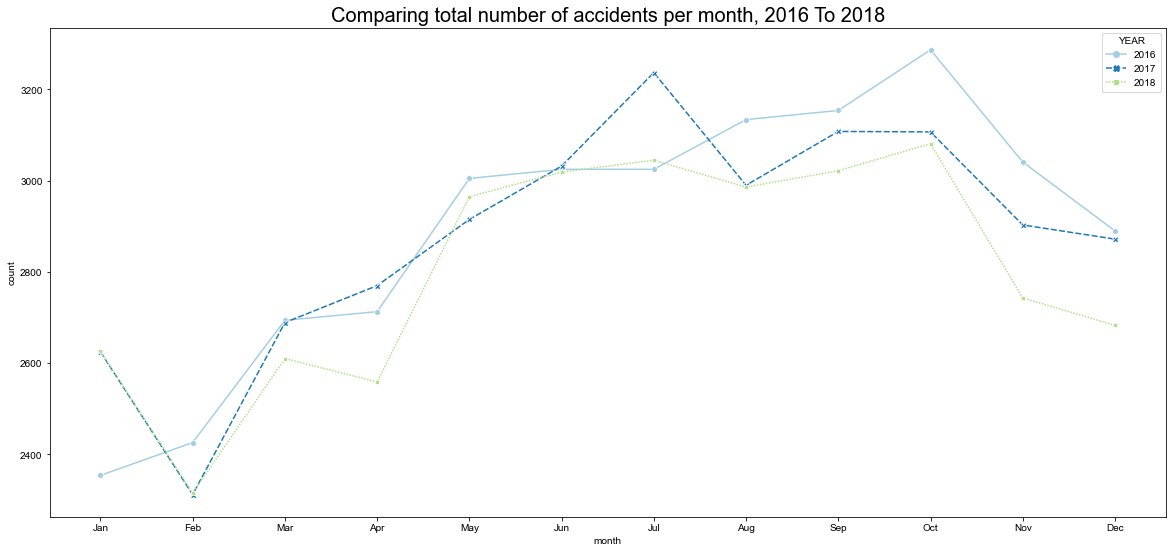

In [24]:
#Comparison of number of fatal accidents from 2016 to 2018
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
yr_month_count['month'] = pd.Categorical(yr_month_count['MONTH_x'], categories=months, ordered=True)
plt.figure(figsize=(20,9))
ax =sns.lineplot(data = yr_month_count, x='month',y='count', hue='YEAR',style="YEAR",ci=None,palette="Paired",markers=True)
ax.set_title('Comparing total number of accidents per month, 2016 To 2018',fontsize=20)
sns.set(font_scale=2)
sns.set_style("white")

plt.show()

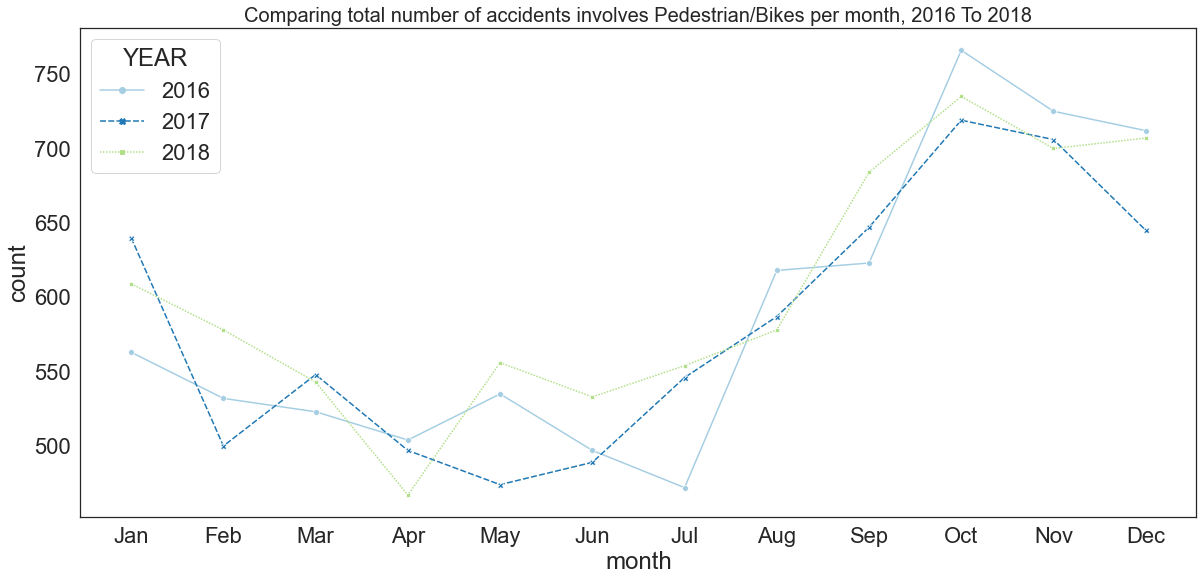

In [25]:
pb=FARS_16_17_18[FARS_16_17_18['PBPTYPE'].notna()]
yr_month_count_pb=pb.groupby(['YEAR','MONTH_x']).ST_CASE.nunique().reset_index().rename(columns={'ST_CASE':'count'})

Months_name = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
          7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
yr_month_count_pb=yr_month_count_pb.replace({"MONTH_x": Months_name})

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
yr_month_count_pb['month'] = pd.Categorical(yr_month_count_pb['MONTH_x'], categories=months, ordered=True)
plt.figure(figsize=(20,9))
ax =sns.lineplot(data = yr_month_count_pb, x='month',y='count', hue='YEAR',style="YEAR",ci=None,palette="Paired",markers=True)
ax.set_title('Comparing total number of accidents involves Pedestrian/Bikes per month, 2016 To 2018',fontsize=20)
sns.set(font_scale=2)
sns.set_style("white")

plt.show()

In [26]:
#Create copy of data
FARS=FARS_16_17_18.copy()
CRSS=CRSS_16_17_18.copy()

#Convert Latitude and Longitude to radians
FARS['Lat_rad'] = FARS['LATITUDE'] * np.pi / 180
FARS['Lon_rad'] = FARS['LONGITUD'] * np.pi / 180

#Replace integer with actual values
Light_Cond = {1:"Daylight", 2:"Dark – Not Lighted", 3:"Dark – Lighted", 4:"Dawn", 5:"Dusk", 6:"Dark – Unknown Lighting", 
          7:"Other", 8:"Not Reported", 9:"Unknown/Reported as Unknown", 10:"Oct", 11:"Nov", 12:"Dec"}
FARS=FARS.replace({"LGT_COND": Light_Cond})
CRSS=CRSS.replace({"LGT_COND": Light_Cond})

Alc_inv = {1:"Alcohol Involved", 2:"No Alcohol Involved",  8:"No Applicable Person",9:"Unknown"}
CRSS=CRSS.replace({"ALCOHOL": Alc_inv})

Weather_str={0:"No Additional Atmospheric Conditions", 1:"Clear", 2:"Rain", 3:"Sleet or Hail", 4:"Snow", 
         5:"Fog, Smog, Smoke", 6:"Severe Crosswinds", 
        7:"Blowing Sand, Soil, Dirt", 8:"Other",  
        10:"Cloudy", 11:"Blowing Snow", 12:"Freezing Rain or Drizzle",
        98:"Unknown/Reported as Unknown",
        99:"Unknown/Reported as Unknown"}
FARS=FARS.replace({"WEATHER": Weather_str})
CRSS=CRSS.replace({"WEATHER": Weather_str})

Manner_collison={0:"Not Collision with Motor Vehicle in Transport", 1:"Front-to-Rear", 2:"Front-to-Front",
                 3:"Angle – Front-to-Side, Same Direction", 4:"Angle – Front-to-Side, Opposite Direction", 
         5:"Angle – Front-to-Side, Right Angle (Includes Broadside)", 
        6:"Angle – Front-to-Side/Angle-Direction Not Specified", 
        7:"Sideswipe – Same Direction", 8:"Sideswipe – Opposite Direction",
        9:"Rear-to-Side",
        10:"Rear-to-Rear", 11:"Other (End-Swipes and Others)", 
        98:"Not Reported",
        99:"Unknown/Reported as Unknown"}
FARS=FARS.replace({"MAN_COLL_x": Manner_collison})
CRSS=CRSS.replace({"MAN_COLL_x": Manner_collison})


Rel_Roads={1:"On Roadway", 2:"On Shoulder", 3:"On Median", 4:"On Roadside", 
         5:"Outside Trafficway", 6:"Off Roadway – Location Unknown", 
        7:"In Parking Lane/Zone", 8:"Gore",  
        10:"Separator", 11:"Continuous Left Turn Lane", 
        12:"Unknown/Reported as Unknown",
        98:"Not Reported",
        99:"Unknown/Reported as Unknown"}

FARS=FARS.replace({"REL_ROAD": Rel_Roads})
CRSS=CRSS.replace({"REL_ROAD": Rel_Roads})


Level_Damage_Veh={0:"No Damage", 2:"Minor Damage", 4:"Functional Damage", 
         6:"Disabling Damage", 8:"Not Reported", 
     9:"Reported as Unknown"
        }

FARS=FARS.replace({"DEFORMED": Level_Damage_Veh})
CRSS=CRSS.replace({"DEFORMED": Level_Damage_Veh})


Haz_Involve={1:"No", 2:"Yes"
        }

FARS=FARS.replace({"HAZ_INV": Haz_Involve})
CRSS=CRSS.replace({"HAZ_INV": Haz_Involve})

Roll_over={0:"No Rollover", 1:"Rollover, Tripped by Object/Vehicle Subsequent Event",
           2:"Rollover, Untripped",
           9:"Rollover, Unknown Type"
        }

FARS=FARS.replace({"ROLLOVER": Roll_over})
CRSS=CRSS.replace({"ROLLOVER": Roll_over})


Fire={0:"No or Not Reported", 1:"Yes"}

FARS=FARS.replace({"FIRE_EXP": Fire})
CRSS=CRSS.replace({"FIRE_EXP": Fire})

In [27]:
#The parts below is for fatal accidents analysis

Sur_type={0:"Non-Trafficway or Driveway Access",
         1:"Concrete",
         2:"Blacktop, Bituminous, or Asphalt",
         3:"Brick or Block",
         4:"Slag, Gravel or Stone",
         5:"Dirt",
         7:"Other",
         8:"Not Reported",
         9:"Unkown/Reported as Unknown"}

FARS=FARS.replace({"VPAVETYP": Sur_type})

Surf_cond={0:"Non-Trafficway Area or Driveway Access",
          1:"Dry",
          2:"Wet",
          3:"Snow",
          4:"Ice/Frost",
          5:"Sand",
          6:"Water (Standing or Moving)",
          7:"Oil",
          8:"Other",
          10:"Slush",
          11:"Mud, Dirt, Gravel",
          98:"Not Reported",
          99:"Unknown/Reported as Unknown"}

FARS=FARS.replace({"VSURCOND": Surf_cond}) 


Vehicle_make={1:"American Motors",
             2:"Jeep/Kaiser-Jeep/Willys Jeep",
             3:"AM General",
             6:"Chrysler",
             7:"Dodge",
             8:"Imperial",
             9:"Plymouth",
             10:"Eagle",
             12:"Ford",
             13:"Lincoln",
             14:"Mercury",
             18:"Buick/Opel",
             19:"Cadillac",
             20:"Chevrolet",
             21:"Oldsmobile",
             22:"Pontiac",
             23:"GMC",
             24:"Saturn",
             25:"Grumman",
             26:"Coda (Since 2013)",
             29:"Other Domestic (Avanti Checker DeSoto Excalibur Hudson Packard Panoz Saleen Studebaker Stutz Tesla (Since 2014))",
             30:"30 Volkswagen",
             31:"Alfa Romeo",
             32:"Audi",
             33:"Austin/Austin Healey",
             34:"BMW",
             35:"Datsun/Nissan",
             36:"Fiat",
             37:"Honda",
             38:"Isuzu",
             39:"Jaguar",
             40:"Lancia",
             41:"Mazda",
             42:"Mercedes-Benz",
             43:"MG",
             44:"Peugeot",
             45:"Porsche",
             46:"Renault",
             47:"Saab",
             48:"Subaru",
             49:"Toyota",
             50:"Triumph",
             51:"Volvo",
             52:"Mitsubishi",
             53:"Suzuki",
             54:"Acura",
             55:"Hyundai",
             56:"Merkur",
             57:"Yugo",
             58:"Infiniti",
             59:"Lexus",
             60:"Daihatsu",
             61:"Sterling",
             62:"Land Rover",
             63:"Kia",
             64:"Daewoo",
             65:"Smart (Since 2010)",
             66:"Mahindra (2011-2013)",
             67:"Scion (Since 2012)",
             69:"Other Imports (such as Aston Martin Bentley Bertone Bricklin Bugatti Caterham Citroen DeLorean Desta Ferrari Lamborghini Mini Cooper Morgan",
             70:"BSA",
             71:"Ducati",
             72:"Harley-Davidson",
             73:"Kawasaki",
             74:"Moto Guzzi",
             75:"Norton",
             76:"Yamaha",
             77:"Victory",
             78:"Other Make Moped (Since 2010)",
             79:"Other Make Motored Cycle (Since 2010)",
             80:"Brockway",
             81:"Diamond Reo/Reo",
             82:"Freightliner",
             83:"FWD",
             84:"International Harvester/Navistar",
             85:"Kenworth",
             86:"Mack",
             87:"Peterbilt",
             88:"Iveco/Magirus",
             89:"White/Autocar, White/GMC",
             90:"Bluebird",
             91:"Eagle Coach",
             92:"Gillig",
             93:"MCI",
             94:"Thomas Built",
             97:"Not Reported (Since 2010)",
             98:"Other Make Auto-Union-DKW Carpenter Collins Bus DINA Divco Hino Mid Bus Neoplan Orion Oshkosh Scania Sterling UD Van Hool Western Star",
             99:"Unknown Make"}


FARS=FARS.replace({"MAKE": Vehicle_make})              
     
Bodytype={1:"Convertible (Excludes Sunroof, T-Bar)", 
          2:"2-Door Sedan/Hardtop/Coupe",         
          3:"3-Door/2-Door Hatchback",
          4:"4-Door Sedan/Hardtop",
          5:"5-Door/4-Door Hatchback",
          6:"Station Wagon (Excluding Van and Truck-Based)",
          7: "Hatchback, Number of Doors Unknown",
          8:"Sedan/Hardtop, Number of Doors Unknown (Since 1994)",
          9:"Other or Unknown Automobile Type (Since 1994)",
          10:"Auto-Based Pickup",
          11:"Auto-Based Panel (Cargo Station Wagon, Auto-Based Ambulance or Hearse)",
          12:"Large Limousine – More Than Four Side Doors or Stretch Chassis",
          13:"Three-Wheel Automobile or Automobile Derivative",
          14:"Compact Utility (ANSI D-16 Utility Vehicle Categories “Small” and “Midsize”)",
          15:"Large Utility (ANSI D-16 Utility Vehicle Categories “Full Size” and “Large”)",
          16:"Utility Station Wagon",
          17:"3-Door Coupe",
          19:"Utility Unknown Body",
          20:"Minivan",
          21:"Large Van – Includes Van-Based Buses",
          22:"Step Van or Walk-In Van (GVWR ≤ 10,000 lbs)",
          28:"Other Van Type (Hi-Cube Van)",
          29:"Unknown Van Type",
          30:"Compact Pickup (GVWR, < 4,500 lbs)",
          31:"Standard Pickup (4,500 lbs <= GVWR < 10,000 lbs)",
          32:"Pickup with Slide-In Camper",
          33:"Convertible Pickup",
          34:"Light Pickup",
          39:"Unknown (Pickup Style) Light Conventional Truck Type",
          40:"Cab Chassis-Based (Includes Light Stake, Light Dump, Light Tow, Rescue Vehicles)",
          41:"Truck-Based Panel",
          42:"Light-Truck-Based Motorhome (Chassis Mounted)",
          45:"Other Light Conventional Truck Type (Includes Stretched Suburban Limousine)",
          48:"Unknown Light Truck Type (Since 2013)",
          49:"Unknown Light-Vehicle Type (Automobile, Utility Vehicle, Van or Light Truck)",
          50:"School Bus",
          51:"Cross-Country/Intercity Bus (i.e., Greyhound)",
          52:"Transit Bus (City Bus)",
          55:"Van-Based Bus (GVWR > 10,000 lbs) (Since 2011)",
          58:"Other Bus Type",
          59:"Unknown Bus Type",
          60:"Step Van (GVWR > 10,000 lbs.)",
          61:"Single-Unit Straight Truck or Cab-Chassis (GVWR range 10,001 to 19,500 lbs) (Since 2011)",
          62:"Single-Unit Straight Truck or Cab-Chassis (GVWR range 19,501 to 26,000 lbs) (Since 2011)",
          63:"Single-Unit Straight Truck or Cab-Chassis (GVWR > 26,000 lbs) (Since 2011)",
          64:"Single Unit Straight Truck or Cab-Chassis (GVWR Unknown) (Since 2011)",
          65:"Medium/Heavy Truck-Based Motorhome",
          66:"Truck/Tractor (Cab Only, or with Any Number of Trailing Units: Any Weight)",
          67:"Medium/Heavy Pickup (GVWR > 10,000 lbs) (Since 2001)",
          72:"Unknown if Single-Unit or Combination-Unit Heavy Truck (GVWR > 26,000 lbs)",
          73:"Camper or Motorhome, Unknown Truck Type",
          78:"Unknown Medium/Heavy Truck Type",
          79:"Unknown Truck Type",
          80:"Two Wheel Motorcycle (excluding motor scooters)",
          81:"Moped or Motorized Bicycle",
          82:"Three-Wheel Motorcycle (2 Rear Wheels)",
          83:"Off-Road Motorcycle",
          84:"Motor Scooter",
          85:"Unenclosed 3-Wheel Motorcycle / Unenclosed Autocycle (1 Rear Wheel)",
          86:"Enclosed 3-Wheel Motorcycle / Enclosed Autocycle (1 Rear Wheel)",
          87:"Unknown Three Wheel Motorcycle Type",
          88:"Other Motored Cycle Type (Mini-Bikes, Pocket Motorcycles, 'Pocket Bikes')",
          89:"Unknown Motored Cycle Type",
          90:"ATV (All-Terrain Vehicle; Includes 3 or 4 Wheels)",
          91:"Snowmobile",
          92:"Farm Equipment Other Than Trucks",
          93:"Construction Equipment Other Than Trucks (Includes Graders)",
          94:"Low Speed Vehicle (LSV)/Neighborhood Electric Vehicle (NEV) (Since 2011)",
          95:"Golf Cart (Since 2012)",
          96:"Recreational Off-Highway Vehicle",
          97:"Other Vehicle Type (Includes Go-Cart, Fork-Lift, City Street Sweeper, Dune/Swamp Buggy)",
          98:"Not Reported",
          99:"Unknown Body Type"}  
FARS=FARS.replace({"BODY_TYP": Bodytype})  



### Let's compare major factors between fatal crash and injury-only crash.

##### First, let's take a look at light condition between Fatal and Injury-only Crash.
From the visualization, the majority of accidents in both types of accidents happen under the condition of 'Daylight'. However, more percentage of fatal accidents happened in 'Dark-Lighted', 'Dark-Not lighted' compared to injury-only accidents. 
So light condition is an important factor.

In [28]:
FARS_LG=FARS.groupby(['LGT_COND'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_LG=FARS_LG.set_index(['LGT_COND'])
FARS_LG["%"] = FARS_LG.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+ '%'

CRSS_LG=CRSS.groupby(['LGT_COND'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_LG=CRSS_LG.set_index(['LGT_COND'])
CRSS_LG["%"] = CRSS_LG.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+ '%'

FARS_LG_styler = FARS_LG.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_LG_styler = CRSS_LG.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_LG_styler._repr_html_()+CRSS_LG_styler._repr_html_(), raw=True)

,COUNT,%
LGT_COND,,
Dark – Lighted,16176,22.37%
Dark – Not Lighted,21133,29.23%
Dark – Unknown Lighting,721,1.0%
Dawn,1887,2.61%
Daylight,29466,40.75%
Dusk,2348,3.25%
Not Reported,70,0.1%
Other,46,0.06%
Unknown/Reported as Unknown,461,0.64%


In [29]:
CRSS_LG['Type']='Injury Only'
FARS_LG['Type']='Fatal'
frames = [CRSS_LG, FARS_LG]
LG_Concat=pd.concat(frames)
LG_Concat.reset_index(inplace=True)

In [30]:
base=alt.Chart(LG_Concat).encode(
    alt.X('Type:N',axis=alt.Axis(grid=False)),
    alt.Y('COUNT:Q',axis=alt.Axis(grid=False)),
    color='Type:N'
   
).properties(width=80)

text = base.mark_text(
    align='center',
    baseline='top',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='%:N',
    color='black'
)

alt.layer(
  base.mark_bar(),
  base.mark_text(dx=0, dy=-10).encode(text='%:N')
).facet(
  column='LGT_COND:N'
)

alt.FacetChart(...)

In [31]:
#FARS.dropna(subset=['LGT_COND'],inplace = True)
#CRSS.dropna(subset=['LGT_COND'],inplace = True)
#FARS_sort = FARS.sort_values('LGT_COND',ascending=True)
#CRSS_sort = CRSS.sort_values('LGT_COND',ascending=True)
#f,ax=plt.subplots(1,2,figsize=(15,11))
#sns.set(font_scale=1)
#rc={'font.size': 12, 'axes.labelsize': 12, 
#     'axes.titlesize': 15, 'xtick.labelsize':12, 'ytick.labelsize': 12}
#sns.set_context(rc=rc)
#sns.set_style("white")

#sns.histplot(FARS_sort["LGT_COND"],ax=ax[0])
#ax[0].set_title('Distribution of Light Condition - Fatal Accident')
#plt.setp(ax[0].get_xticklabels(), rotation=90)
#ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)


#sns.histplot(CRSS_sort["LGT_COND"],ax=ax[1])
#ax[1].set_title('Distribution of Light Condition - Injury-Only')
# plt.setp(ax[1].get_xticklabels(), rotation=90)
# plt.show()


##### Next, let's take a look and see if single car accident/multi-car accident is another factor leading to fatal accidents.
So from the chart below, it is surprisingly that among fatal accidents, 48% of fatal accidents are single vehicle accidents while only 28% of injury-only are single-vehicle accidents. 

In [32]:
#from IPython.display import display_html 
FARS_ve=FARS.groupby(['VE_TOTAL'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_ve=FARS_ve.set_index(['VE_TOTAL'])
FARS_ve["%"] = FARS_ve.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+ '%'

CRSS_ve=CRSS.groupby(['VE_TOTAL'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_ve=CRSS_ve.set_index(['VE_TOTAL'])
CRSS_ve["%"] = CRSS_ve.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+ '%'

FARS_ve_styler = FARS_ve.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_ve_styler = CRSS_ve.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_ve_styler._repr_html_()+CRSS_ve_styler._repr_html_(), raw=True)

,COUNT,%
VE_TOTAL,,
1,32185,48.59%
2,25809,38.96%
3,5897,8.9%
4,1449,2.19%
5,510,0.77%
6,195,0.29%
7,84,0.13%
8,40,0.06%
9,29,0.04%


In [33]:
CRSS_ve['Type']='Injury Only'
FARS_ve['Type']='Fatal'
frames2 = [CRSS_ve, FARS_ve]
ve_Concat=pd.concat(frames2)
ve_Concat.reset_index(inplace=True)
ve_Concat=ve_Concat[ve_Concat['VE_TOTAL']<=8]

In [34]:
base=alt.Chart(ve_Concat).encode(
    alt.X('Type:N',axis=alt.Axis(grid=False)),
    alt.Y('COUNT:Q',axis=alt.Axis(grid=False)),
    color='Type:N'
   
).properties(width=80)

text = base.mark_text(
    align='center',
    baseline='top',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='%:N'
)

alt.layer(
  base.mark_bar(),
  base.mark_text(dx=0, dy=-10).encode(text='%:N')
).facet(
  column='VE_TOTAL:N'
)

alt.FacetChart(...)

In [35]:
# FARS_ve=FARS_ve.reset_index()
# CRSS_ve=CRSS_ve.reset_index()

# f,ax=plt.subplots(1,2,figsize=(15,10))
# sns.set(font_scale=1)
# rc={'font.size': 10, 'axes.labelsize': 12, 
#     'axes.titlesize': 15, 'xtick.labelsize':10, 'ytick.labelsize': 10}
# sns.set_context(rc=rc)
# sns.set_style("white")
# sns.barplot(x='VE_TOTAL',y='COUNT',ax=ax[0],data=FARS_ve)
# #sns.histplot(FARS["VE_TOTAL"],ax=ax[0],binwidth=1)
# ax[0].set_title('Distribution of Total Vehicles Involved - Fatal Accident')
# ax[0].set(xlim=(0,8))
# ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

# sns.barplot(x='VE_TOTAL',y='COUNT',ax=ax[1],data=CRSS_ve)
# #sns.histplot(CRSS["VE_TOTAL"],ax=ax[1],binwidth=1)
# ax[1].set_title('Distribution of Total Vehicles Involved - Injury-Only')
# ax[1].set(xlim=(0,8))
    
# plt.show()



##### As alcohol involvement is a critical factor for accident, let's compare it.
It's good that we see the majority in both fatal and injury-only accidents are non-alcohol involved.
However, if we compare fatal with injury-only, we could see that 37.42% of fatal accidents has at least 1 drunk driver involved.

In [36]:
#from IPython.display import display_html 
FARS_al=FARS.groupby(['DRUNK_DR'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_al=FARS_al.set_index(['DRUNK_DR'])
FARS_al["%"] = FARS_al.apply(lambda x:  100*x / x.sum()).round(2).astype('str')+'%'

CRSS_al=CRSS.groupby(['ALCOHOL'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_al=CRSS_al.set_index(['ALCOHOL'])
CRSS_al["%"] = CRSS_al.apply(lambda x:  100*x / x.sum()).round(2).astype('str')+'%'

FARS_al_styler = FARS_al.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_al_styler = CRSS_al.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_al_styler._repr_html_()+CRSS_al_styler._repr_html_(), raw=True)

,COUNT,%
DRUNK_DR,,
0,35018,62.59%
1,20128,35.97%
2,796,1.42%
3,9,0.02%
4,1,0.0%
,COUNT,%
ALCOHOL,,
Alcohol Involved,7298,4.87%
No Alcohol Involved,121751,81.21%


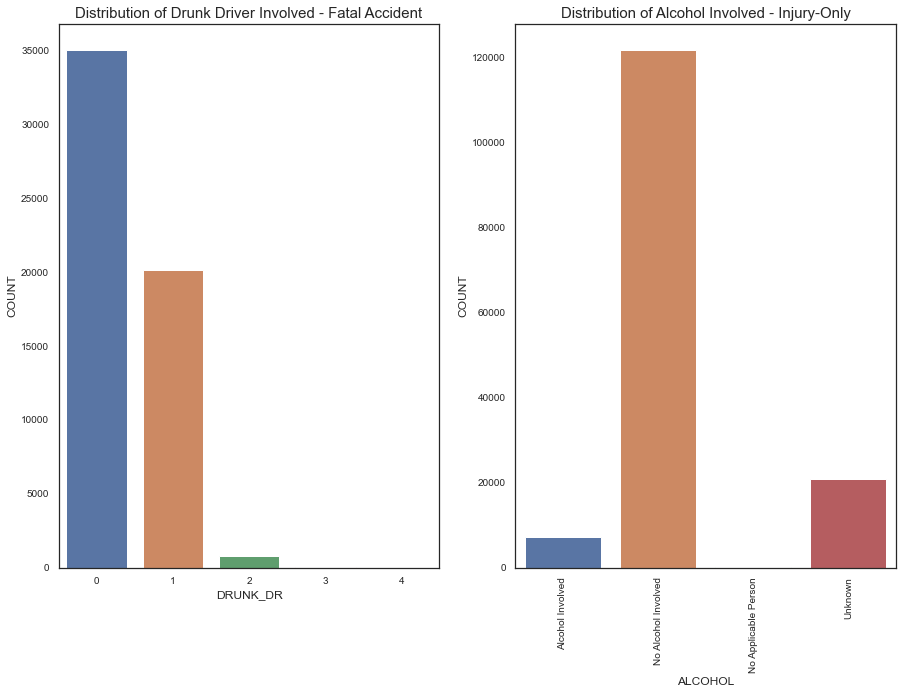

In [85]:
# #FARS_al=FARS_al.reset_index()
# #CRSS_al=CRSS_al.reset_index()

# f,ax=plt.subplots(1,2,figsize=(15,10))
# sns.set(font_scale=1)
# rc={'font.size': 10, 'axes.labelsize': 12, 
#     'axes.titlesize': 15, 'xtick.labelsize':10, 'ytick.labelsize': 10}
# sns.set_context(rc=rc)
# sns.set_style("white")
# sns.barplot(x='DRUNK_DR',y='COUNT',ax=ax[0],data=FARS_al)
# #sns.histplot(FARS["DRUNK_DR"],ax=ax[0],binwidth=1)
# ax[0].set_title('Distribution of Drunk Driver Involved - Fatal Accident')
# ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)


# sns.barplot(x='ALCOHOL',y='COUNT',ax=ax[1],data=CRSS_al)
# #sns.histplot(CRSS["ALCOHOL"],ax=ax[1],binwidth=2)
# ax[1].set_title('Distribution of Alcohol Involved - Injury-Only')
# plt.setp(ax[1].get_xticklabels(), rotation=90)


# plt.show()

In [84]:
from altair import expr, datum
bar1=alt.Chart(FARS_al).mark_bar(strokeWidth=20).encode(
    alt.X('DRUNK_DR:N',axis=alt.Axis(grid=False)),
    alt.Y('COUNT:Q',axis=alt.Axis(grid=False))).properties(
    width=300,
    height=250
)


bar2=alt.Chart(CRSS_al).mark_bar().encode(
    x=alt.X('ALCOHOL:N',axis=alt.Axis(grid=False)),
    y=alt.Y('COUNT:Q',axis=alt.Axis(grid=False)),
    color=alt.value('#ff7f0e')).properties(
    width=300,
    height=250
)

text1 = bar1.mark_text(
    align='center',
    baseline='top',
    dx=2,
    dy=-15# Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='%:N'
)

text2 = bar2.mark_text(
    align='center',
    baseline='top',
    dx=2,
    dy=-15# Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='%:N'
).transform_calculate(
    human_readable_value = expr.toString(expr.floor(datum.value/10)),
    text_margin_from_bar = datum.value + (datum.value/expr.abs(datum.value))*10
)

(bar1+text1)|(bar2+text2)

alt.HConcatChart(...)

##### Now, let's see if weather will lead to more fatal accidents.
From the chart, we could see that the weather distribution is very identical between two type of accidents.
Thus, we may know that weather isn't a key factor that cause fatal accident.

In [128]:
FARS_w=FARS.groupby(['WEATHER'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_w=FARS_w.set_index(['WEATHER'])
FARS_w["%"] = FARS_w.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+ '%'

CRSS_w=CRSS.groupby(['WEATHER'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_w=CRSS_w.set_index(['WEATHER'])
CRSS_w["%"] = CRSS_w.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+ '%'

FARS_w_styler = FARS_w.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_w_styler = CRSS_w.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_w_styler._repr_html_()+CRSS_w_styler._repr_html_(), raw=True)

,COUNT,%
WEATHER,,
"Blowing Sand, Soil, Dirt",37,0.06%
Blowing Snow,67,0.11%
Clear,33117,56.18%
Cloudy,12367,20.98%
"Fog, Smog, Smoke",1143,1.94%
Freezing Rain or Drizzle,59,0.1%
Other,124,0.21%
Rain,6840,11.6%
Severe Crosswinds,161,0.27%


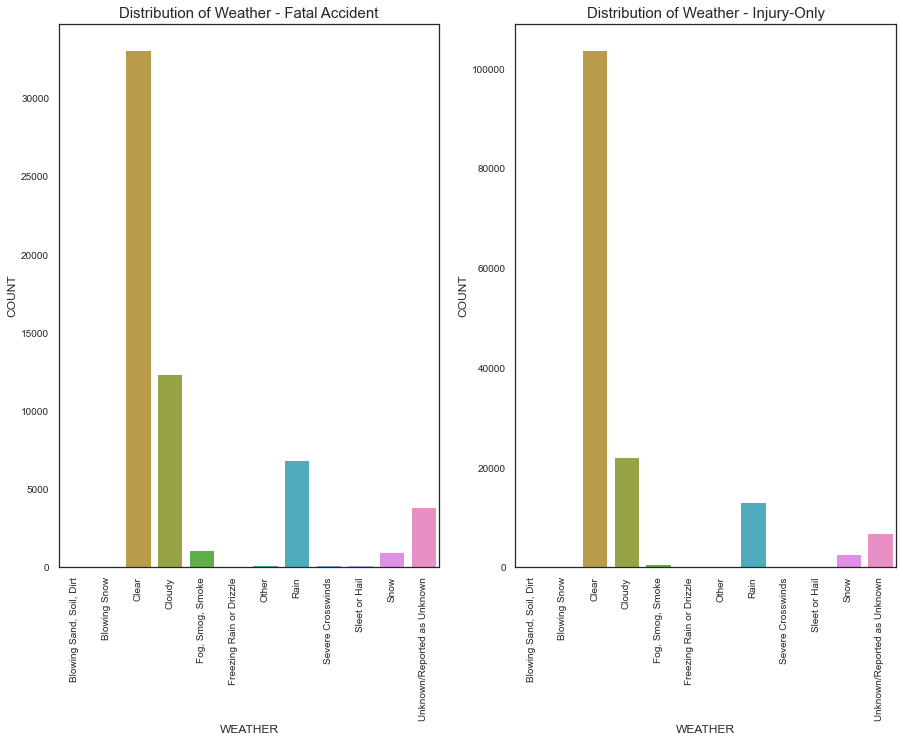

In [127]:
#FARS_sort = FARS.sort_values('WEATHER',ascending=True)
#CRSS_sort = CRSS.sort_values('WEATHER',ascending=True)
FARS_w=FARS_w.reset_index()
CRSS_w=CRSS_w.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")
#FARS.dropna(subset=['WEATHER'],inplace = True)
#CRSS.dropna(subset=['WEATHER'],inplace = True)
sns.barplot(x='WEATHER',y='COUNT',ax=ax[0],data=FARS_w)
#sns.histplot(FARS_sort["WEATHER"],ax=ax[0])
ax[0].set_title('Distribution of Weather - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='WEATHER',y='COUNT',ax=ax[1],data=CRSS_w)
#sns.histplot(CRSS_sort["WEATHER"],ax=ax[1])
ax[1].set_title('Distribution of Weather - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### Next, we will take a look at how the collion manner different between both accidents.
What we have noticed that 48.5% of fatal accidents are 'Not Collision with Motor Vehicle in Transport' which aligns with what we have seen in the factor or single-vehicle/muti-vehicle.
Besides, we find out that more (14.00%) fatal accidents has front-to-front manner of collision compared to 3.7% injury-only accident. 


In [129]:
FARS_col=FARS.groupby(['MAN_COLL_x'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_col=FARS_col.set_index(['MAN_COLL_x'])
FARS_col["%"] = FARS_col.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+'%'

CRSS_col=CRSS.groupby(['MAN_COLL_x'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_col=CRSS_col.set_index(['MAN_COLL_x'])
CRSS_col["%"] = CRSS_col.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+'%'

FARS_col_styler = FARS_col.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_col_styler = CRSS_col.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_col_styler._repr_html_()+CRSS_col_styler._repr_html_(), raw=True)

,COUNT,%
MAN_COLL_x,,
Angle – Front-to-Side/Angle-Direction Not Specified,15557,22.65%
Front-to-Front,9620,14.0%
Front-to-Rear,6775,9.86%
Not Collision with Motor Vehicle in Transport,33291,48.46%
Not Reported,91,0.13%
Other (End-Swipes and Others),275,0.4%
Rear-to-Rear,4,0.01%
Rear-to-Side,109,0.16%
Sideswipe – Opposite Direction,1193,1.74%


In [130]:
CRSS_col['Type']='Injury Only'
FARS_col['Type']='Fatal'
frames3 = [CRSS_col, FARS_col]
col_Concat=pd.concat(frames3)
col_Concat.reset_index(inplace=True)


In [171]:
base=alt.Chart(col_Concat).encode(
    alt.X('Type:N',axis=alt.Axis(grid=False)),
    alt.Y('COUNT:Q',axis=alt.Axis(grid=False)),
    color='Type:N'
   
).properties(width=140,height=500)

text = base.mark_text(
    align='center',
    baseline='top',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='%:N'
)

alt.layer(
  base.mark_bar(),
  base.mark_text(dx=0, dy=-10).encode(text='%:N')
).facet(spacing=25,
  
    column= alt.Column('MAN_COLL_x:N',
        
        header=alt.Header(labelPadding=0,labelFontSize=10.5)
))

alt.FacetChart(...)

In [ ]:
# #FARS_sort = FARS.sort_values('MAN_COLL_x',ascending=True)
# #CRSS_sort = CRSS.sort_values('MAN_COLL_x',ascending=True)
# FARS_col=FARS_col.reset_index()
# CRSS_col=CRSS_col.reset_index()

# f,ax=plt.subplots(1,2,figsize=(15,10))
# sns.set(font_scale=1)
# rc={'font.size': 10, 'axes.labelsize': 12, 
#     'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
# sns.set_context(rc=rc)
# sns.set_style("white")
# #FARS.dropna(subset=['WEATHER'],inplace = True)
# #CRSS.dropna(subset=['WEATHER'],inplace = True)
# sns.barplot(x='MAN_COLL_x',y='COUNT',ax=ax[0],data=FARS_col)
# #sns.histplot(FARS_sort["MAN_COLL_x"],ax=ax[0])
# ax[0].set_title('Distribution of Manner of Collision - Fatal Accident')
# plt.setp(ax[0].get_xticklabels(), rotation=90)
# ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

# sns.barplot(x='MAN_COLL_x',y='COUNT',ax=ax[1],data=CRSS_col)
# #sns.histplot(CRSS_sort["MAN_COLL_x"],ax=ax[1])
# ax[1].set_title('Distribution of Manner of Collision - Injury-Only')
# plt.setp(ax[1].get_xticklabels(), rotation=90)
# plt.show()

##### We are curious to see the position of the crash relates to the trafficway.
The Rel_road variable identifies the location of the crash as it relates to its position within or outside the trafficway.
Combine this information with the manner of collision, we could get more sense of how and where the collison happened in a traffic way.

When we compare both types of accidents, the majority happens 'On Roadway'.
What differs is more (19.81%) fatal accidents happen 'On Roadside' compared to 7.41% of injury-only accident. This further validates that single-vehicle or vehicle that is not in collision with another vehicle is more common in fatal accident.

In [172]:
FARS_rel=FARS.groupby(['REL_ROAD'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_rel=FARS_rel.set_index(['REL_ROAD'])
FARS_rel["%"] = FARS_rel.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+'%'

CRSS_rel=CRSS.groupby(['REL_ROAD'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_rel=CRSS_rel.set_index(['REL_ROAD'])
CRSS_rel["%"] = CRSS_rel.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+'%'

FARS_rel_styler = FARS_rel.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_rel_styler = CRSS_rel.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_rel_styler._repr_html_()+CRSS_rel_styler._repr_html_(), raw=True)

,COUNT,%
REL_ROAD,,
Continuous Left Turn Lane,91,0.14%
Gore,445,0.69%
In Parking Lane/Zone,245,0.38%
Not Reported,47,0.07%
Off Roadway – Location Unknown,338,0.52%
On Median,3761,5.81%
On Roadside,22122,34.2%
On Roadway,33281,51.45%
On Shoulder,1548,2.39%


In [ ]:
#FARS.dropna(subset=['REL_ROAD'],inplace = True)
#CRSS.dropna(subset=['REL_ROAD'],inplace = True)
#FARS_sort = FARS.sort_values('REL_ROAD',ascending=True)
#CRSS_sort = CRSS.sort_values('REL_ROAD',ascending=True)
FARS_rel=FARS_rel.reset_index()
CRSS_rel=CRSS_rel.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

#FARS.dropna(subset=['WEATHER'],inplace = True)
#CRSS.dropna(subset=['WEATHER'],inplace = True)

sns.barplot(x='REL_ROAD',y='COUNT',ax=ax[0],data=FARS_rel)
#sns.histplot(FARS_sort["REL_ROAD"],ax=ax[0])
ax[0].set_title('Distribution of Relationship to TrafficWay - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='REL_ROAD',y='COUNT',ax=ax[1],data=CRSS_rel)
#sns.histplot(CRSS_sort["REL_ROAD"],ax=ax[1])
ax[1].set_title('Distribution of Relationship to TrafficWay - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### According to WHO, accidents that involve hazardous material may lead to more fatal accidents.
Our dataset sample doesn't include much data records which has hazardous material involvement. But by quick check, we still see difference between fatal accidents and injury-only accident. Although we can't conclude that this factor plays large part, but 0.28% of our fatal-accidents records is hazardous material involved, while only 0.05% of our injury-only accidents are hazardous material involved.

In [173]:
FARS_haz=FARS.groupby(['HAZ_INV'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_haz=FARS_haz.set_index(['HAZ_INV'])
FARS_haz["%"] = FARS_haz.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+'%'

CRSS_haz=CRSS.groupby(['HAZ_INV'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_haz=CRSS_haz.set_index(['HAZ_INV'])
CRSS_haz["%"] = CRSS_haz.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+'%'

FARS_haz_styler = FARS_haz.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_haz_styler = CRSS_haz.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_haz_styler._repr_html_()+CRSS_haz_styler._repr_html_(), raw=True)

,COUNT,%
HAZ_INV,,
No,36174,98.8%
Yes,438,1.2%
,COUNT,%
HAZ_INV,,
No,149895,99.91%
Yes,132,0.09%


In [ ]:
#FARS.dropna(subset=['HAZ_INV'],inplace = True)
#CRSS.dropna(subset=['HAZ_INV'],inplace = True)
FARS_haz=FARS_haz.reset_index()
CRSS_haz=CRSS_haz.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")
#FARS.dropna(subset=['WEATHER'],inplace = True)
#CRSS.dropna(subset=['WEATHER'],inplace = True)
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

sns.barplot(x='HAZ_INV',y='COUNT',ax=ax[0],data=FARS_haz)
#sns.histplot(FARS["HAZ_INV"],ax=ax[0])
ax[0].set_title('Distribution of Hazordous Material Involvement - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='HAZ_INV',y='COUNT',ax=ax[1],data=CRSS_haz)
#sns.histplot(CRSS["HAZ_INV"],ax=ax[1])
ax[1].set_title('Distribution of Hazordous Material Involvement - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### Another Important thing to check is whether a rollover is involved in an accident.
It is clear that more rollover occur in fatal accidents which does make sense.

In [ ]:
FARS_roll=FARS.groupby(['ROLLOVER'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_roll=FARS_roll.set_index(['ROLLOVER'])
FARS_roll["%"] = FARS_roll.apply(lambda x:  100*x / x.sum())

CRSS_roll=CRSS.groupby(['ROLLOVER'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_roll=CRSS_roll.set_index(['ROLLOVER'])
CRSS_roll["%"] = CRSS_roll.apply(lambda x:  100*x / x.sum())

FARS_roll_styler = FARS_roll.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_roll_styler = CRSS_roll.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_roll_styler._repr_html_()+CRSS_roll_styler._repr_html_(), raw=True)

In [ ]:
#FARS_sort = FARS.sort_values('ROLLOVER',ascending=True)
#CRSS_sort = CRSS.sort_values('ROLLOVER',ascending=True)
FARS_roll=FARS_roll.reset_index()
CRSS_roll=CRSS_roll.reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.set(font_scale=1)
rc={'font.size': 10, 'axes.labelsize': 12, 
    'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
sns.set_context(rc=rc)
sns.set_style("white")

sns.barplot(x='ROLLOVER',y='COUNT',ax=ax[0],data=FARS_roll)
#sns.histplot(FARS_sort["ROLLOVER"],ax=ax[0])
#sns.displot(FARS_sort,x="ROLLOVER",ax=axes[0], hue="DR_DRINK")
ax[0].set_title('Distribution of Rollover - Fatal Accident')
plt.setp(ax[0].get_xticklabels(), rotation=90)
ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)


sns.barplot(x='ROLLOVER',y='COUNT',ax=ax[1],data=CRSS_roll)
#sns.histplot(CRSS_sort["ROLLOVER"],ax=ax[1])
#sns.displot(CRSS_sort,x="ROLLOVER",ax=axes[1], hue="ALCOHOL")
ax[1].set_title('Distribution of Rollover - Injury-Only')
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.show()

##### One last factor to compare is if fire occured in an accident in a vehicle.
It is obvious that more fatal accidents have fire occurrence.

In [174]:
FARS_fire=FARS.groupby(['FIRE_EXP'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_fire=FARS_fire.set_index(['FIRE_EXP'])
FARS_fire["%"] = FARS_fire.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+'%'

CRSS_fire=CRSS.groupby(['FIRE_EXP'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_fire=CRSS_fire.set_index(['FIRE_EXP'])
CRSS_fire["%"] = CRSS_fire.apply(lambda x:  100*x / x.sum()).round(2).astype(str)+'%'

FARS_fire_styler = FARS_fire.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_fire_styler = CRSS_fire.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_fire_styler._repr_html_()+CRSS_fire_styler._repr_html_(), raw=True)

,COUNT,%
FIRE_EXP,,
No or Not Reported,36155,89.19%
Yes,4380,10.81%
,COUNT,%
FIRE_EXP,,
No or Not Reported,149612,99.68%
Yes,476,0.32%


In [175]:
CRSS_fire['Type']='Injury Only'
FARS_fire['Type']='Fatal'
frames4 = [CRSS_fire, FARS_fire]
fire_Concat=pd.concat(frames4)
fire_Concat.reset_index(inplace=True)

In [177]:
base=alt.Chart(fire_Concat).encode(
    alt.X('Type:N',axis=alt.Axis(grid=False)),
    alt.Y('COUNT:Q',axis=alt.Axis(grid=False)),
    color='Type:N'
   
).properties(width=140)

text = base.mark_text(
    align='center',
    baseline='top',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='%:N'
)

alt.layer(
  base.mark_bar(),
  base.mark_text(dx=0, dy=-10).encode(text='%:N')
).facet(
  column='FIRE_EXP:N'
)

alt.FacetChart(...)

In [ ]:
# FARS_fire=FARS_fire.reset_index()
# CRSS_fire=CRSS_fire.reset_index()

# f,ax=plt.subplots(1,2,figsize=(15,10))
# sns.set(font_scale=1)
# rc={'font.size': 10, 'axes.labelsize': 12, 
#     'axes.titlesize': 15, 'xtick.labelsize':8, 'ytick.labelsize': 8}
# sns.set_context(rc=rc)
# sns.set_style("white")

# sns.barplot(x='FIRE_EXP',y='COUNT',ax=ax[0],data=FARS_fire)
# #sns.histplot(FARS["FIRE_EXP"],ax=ax[0])
# #sns.displot(FARS_sort,x="ROLLOVER",ax=axes[0], hue="DR_DRINK")
# ax[0].set_title('Distribution of Fire Occurrence - Fatal Accident')
# plt.setp(ax[0].get_xticklabels(), rotation=90)
# ax[0].ticklabel_format(style='plain', axis='y', scilimits=(0,0),useOffset=False)

# sns.barplot(x='FIRE_EXP',y='COUNT',ax=ax[1],data=CRSS_fire)
# #sns.histplot(CRSS["FIRE_EXP"],ax=ax[1])
# #sns.displot(CRSS_sort,x="ROLLOVER",ax=axes[1], hue="ALCOHOL")
# ax[1].set_title('Distribution of Fire Occurrence - Injury-Only')
# plt.setp(ax[1].get_xticklabels(), rotation=90)
# plt.show()

### Now, we will focus more on fatal-crash and find if there's any patterns among this type of accident.

##### Let's first take a look at hours that most fatal crash accident happen.
From the combo chart below, we are able to find out that fatal accidents also follow peak hours.
While the bars are showing number of fatals by hours which are very identical among hours.
However, we could notice that drunk driver involved fatal accidents increases in the evening and reaches the top at 2 o'clock.

In [ ]:
FARS_hour = FARS[FARS['HOUR_x']<99]
FARS_hour2=FARS_hour.groupby(['HOUR_x','DR_DRINK'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})

In [ ]:
fig, ax1 = plt.subplots(figsize=(18,10))
color = 'tab:green'
#bar plot creation
ax1.set_title('Number of Fatals by Hour', fontsize=16)
ax1.set_xlabel('HOUR_x', fontsize=16)
ax1.set_ylabel('Number of Fatals', fontsize=16,color='red')
ax1 = sns.barplot(data=FARS_hour, x='HOUR_x',y='FATALS',palette='Reds')
ax1.tick_params(axis='y')
ax1.grid(False)

ax2 = ax1.twinx()
#color = 'tab:red'
#line plot creation
ax2.set_ylabel('Number of Accidents', fontsize=16,color='Orange')
ax2 = sns.lineplot(data=FARS_hour2, x='HOUR_x',y='COUNT',hue='DR_DRINK',style='DR_DRINK',palette="Set2")
ax2.tick_params(axis='y')
ax2.grid(False)
#show plot
plt.show()

##### Now, let's look at the relationship between number of vehicle involves vs damage level of vehicles.
From the heatmap, we could see that single vehicle accidents have most cases in 'disabling damage' for fatal accidents which align with our findings in previous section.

In [ ]:
heatmap_dam_ve=FARS.groupby(['DEFORMED','VE_TOTAL'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})


In [ ]:
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches

heatmap_dam_ve_2 = pd.pivot_table(data=heatmap_dam_ve,
                    index='DEFORMED',
                    values='COUNT',
                    columns='VE_TOTAL')
sns.heatmap(heatmap_dam_ve_2,cmap='coolwarm',annot=True,fmt=".1f",annot_kws={'size':12},linewidths=.5, ax=ax)
plt.show()

##### Let's see if speeding is directly related to fatal accident.
Speed_rel records whether the driver's speed was related to the crash as indicated by law enforcement.

So we can see that 21.31% of fatal accidents is directly related to speeding. Among which, 6.9% exceeded speed limit and 7.6% is too fast for conditions. This implies that speeding is one of the major reason leads to fatal accident. Although we have educated drivers not to exceed speed limit and drive not too fast, there are still lots of space to improve.

In [ ]:
Speed_rel={0:"No", 2:"Yes, Racing", 3:"Yes, Exceeded Speed Limit", 
         4:"Yes, Too Fast for Conditions", 5:"Yes, Specifics Unknown",
           8:"No Driver Present/Unknown if Driver Present",
     9:"Reported as Unknown"
        }

FARS=FARS.replace({"SPEEDREL": Speed_rel})



conditions = [
    (FARS['SPEEDREL'] == 'Yes, Racing') | (FARS['SPEEDREL'] == 'Yes, Exceeded Speed Limit')|(FARS['SPEEDREL'] == 'Yes, Too Fast for Conditions')
    |(FARS['SPEEDREL'] == 'Yes, Specifics Unknown')
    ,(FARS['SPEEDREL'] == 'No')| (FARS['SPEEDREL'] == 'No Driver Present/Unknown if Driver Present'),
 (FARS['SPEEDREL'] == 'Reported as Unknown')]
choices = ['Yes, speed related crash', 'No','Unknown']
FARS['SPEEDREL_BIN'] = np.select(conditions, choices, default='Unknown')

In [ ]:
FARS_sp=FARS.groupby(['SPEEDREL'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_sp=FARS_sp.set_index(['SPEEDREL'])
FARS_sp["%"] = FARS_sp.apply(lambda x:  100*x / x.sum())

CRSS_sp=CRSS.groupby(['SPEEDREL'])['CASENUM'].nunique().reset_index().rename(columns={'CASENUM':'COUNT'})
CRSS_sp=CRSS_sp.set_index(['SPEEDREL'])
CRSS_sp["%"] = CRSS_sp.apply(lambda x:  100*x / x.sum())

FARS_sp_styler = FARS_sp.style.set_table_attributes("style='display:inline'").set_caption('Fatal-accident')
CRSS_sp_styler = CRSS_sp.style.set_table_attributes("style='display:inline'").set_caption('Injury-Only accident')

display_html(FARS_sp_styler._repr_html_()+CRSS_sp_styler._repr_html_(), raw=True)

##### We already know that speed is critical factor, and let's combine it with the level of damage of vehicles.
From the box plot, we can confirm that the level of damage is more severe as travelling speed increases.
We have further categorize the accident based on speed_rel and the color grey marks the accident which is speed related according to law enforcement. 
We could see that in the most severe damage 'Disabling damage', the overall travelling speed is higher compared to the other level of damage. And at the same time, the 'speed related crash' has the highest median speed at 70 mph.
From this plot, we could learn that speed is also directly related to vehicle level of damage.

In [ ]:
Fars_dedup=FARS.drop_duplicates(['ST_CASE','DEFORMED','SPEEDREL_BIN','TRAV_SP'])[['ST_CASE','DEFORMED','SPEEDREL_BIN','TRAV_SP']]

In [ ]:
FARS_Trv_sp = Fars_dedup[Fars_dedup['TRAV_SP']<997]
FARS_Trv_sp = FARS_Trv_sp.sort_values('SPEEDREL_BIN',ascending=True)
plt.figure(figsize=(15,8))
ax=sns.boxplot(x = 'DEFORMED', y = 'TRAV_SP', hue="SPEEDREL_BIN", data = FARS_Trv_sp,linewidth=2,fliersize=5,palette="Set2") 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.set(font_scale =1)
ax.set(ylim=(0, 200))
ax.set_title('Travel Speed by Damage Level',fontsize=18)
sns.set_style("white")

#Let's show the median values in the plot.
m1 = FARS_Trv_sp.groupby(['DEFORMED',"SPEEDREL_BIN"])['TRAV_SP'].median().values
mL1 = [str(np.round(s, 2)) for s in m1]


ind = 0
for tick in range(len(ax.get_xticklabels())):
    ax.text(tick, m1[ind+1]+m1[ind+1]*0.1, mL1[ind+1],  horizontalalignment='center', size='medium', color='blue', weight='bold')
    ax.text(tick+0.25, m1[ind+2]+m1[ind+2]*0.1, mL1[ind+2],  horizontalalignment='center', size='medium', color='blue', weight='bold')
    ax.text(tick-0.25, m1[ind]+m1[ind]*0.1, mL1[ind], horizontalalignment='center', size='medium',color='blue', weight='bold')
    ind += 3 

plt.show()


##### Let's take a further look and see if surface type and surface conditions plays a role in fatal accident.
From the heatmap below, we could see that the majority of accidents occur on 'Blacktop, Bituminous, or Saphalt' when it is 'dry', the other surface condition that has slightly more fatal accidents is 'wet'. But this is mostly due to these two conditions are more likely to occur among all seasons.

In [ ]:
heatmap_surface=FARS.groupby(['VPAVETYP','VSURCOND'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches

heatmap_surface_2 = pd.pivot_table(data=heatmap_surface,
                    index='VPAVETYP',
                    values='COUNT',
                    columns='VSURCOND')
sns.heatmap(heatmap_surface_2,cmap='flare',annot=True,fmt=".1f",annot_kws={'size':12},linewidths=.5, ax=ax)
plt.show()

##### Finally, let's take a look at the body type, make in fatal accidents and combine the level of damage. 
So we can see from the Sunburst plot, the body type that has most accidents is 4-door sedan,compact utility, light pickup, two wheel motorcycle and truck. The top five vehicle make are Toyota, Chevrolet,Ford, Harley-Davidson, and Honda.
It is likely because the majority of vehicles purchased by consumers are these brands and body type, but what worths note is that two wheel motorcycle tends to have higher fatal accident rate if compared the ownership of other body types of vehicles.

In [ ]:
FARS_VEHICLE=FARS.groupby(['BODY_TYP'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_VEHICLE_sort =FARS_VEHICLE.sort_values('COUNT',ascending=False)
FARS_VEHICLE_TOP20=FARS_VEHICLE_sort.head(20)
FARS_VEHICLE_TOP20

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))  
sns.barplot(x = 'COUNT', y = 'BODY_TYP',data = FARS_VEHICLE_TOP20,
             color = 'b', edgecolor = 'w')
plt.show()

In [ ]:
FARS_VEHICLE_m_t=FARS.groupby(['BODY_TYP','MAKE','DEFORMED'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_VEHICLE_m_t_sort =FARS_VEHICLE_m_t.sort_values('COUNT',ascending=False)
FARS_VEHICLE_m_t_sort_TOP30=FARS_VEHICLE_m_t_sort.head(30)
FARS_VEHICLE_m_t_sort_TOP30

In [ ]:
import plotly.express as px 
fig = px.sunburst(FARS_VEHICLE_m_t_sort_TOP30, path=['BODY_TYP', 'MAKE'],  
                  values='COUNT',color='COUNT') 
fig.show()

### Now, let's take a look at cities with high cyclists involved fatal accidents.

Initially, we would like to see the top cities with more fatal accidents involving bike. However, after checking the number of accidents in these top 10 cities with most fatal accidents, we find out the number of accident is just too low to be analyzed as a sample which will not be able to be representative. Thus, we choose not to report this portion as an analysis result.

In [ ]:
top_cities['City'] = top_cities['City'].str.upper() 
top_cities['State[c]'] = top_cities['State[c]'].str.upper() 

In [ ]:
FARS['Bike_IND'] = np.where((FARS['PBPTYPE']==6)|(FARS['PBPTYPE']==7), "Yes", "No")

FARS_bk=FARS.groupby(['Bike_IND','State Name','City Name'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
FARS_bk_inv=FARS_bk[FARS_bk['Bike_IND']=='Yes']
FARS_bk_inv.drop(['Bike_IND'],axis=1,inplace=True)
FARS_bk_inv.sort_values('COUNT',ascending=False).head(10)
FARS_bk_inv=FARS_bk_inv.set_index(['State Name','City Name'])

FARS_bk_inv["%"] = FARS_bk_inv.apply(lambda x:  100*x / x.sum())
FARS_bk_inv

In [ ]:
FARS_bk_inv=FARS_bk_inv.reset_index()
FARS_bk_TOP10=FARS_bk_inv.sort_values('%',ascending=False).head(10)

In [ ]:
FARS_bk_TOP10_Popu=pd.merge(FARS_bk_TOP10, top_cities[['City','State[c]','2010Census','2016 land area','2016 population density']],  how='left', left_on=['City Name','State Name'], right_on = ['City','State[c]'])

In [ ]:
FARS_bk_TOP10_Popu

In [ ]:
bike_only=FARS[FARS['Bike_IND']=='Yes']
PB_Popu=pd.merge(bike_only, top_cities[['City','State[c]','2016 land area','2010Census','2016 population density']],  how='left', left_on=['City Name','State Name'], right_on = ['City','State[c]'])

In [ ]:
PB_Popu_6state=PB_Popu[PB_Popu['State Name'].isin(['CALIFORNIA', 'ARIZONA','TEXAS','NEW YORK','ILLINOIS','FLORIDA'])]

In [ ]:
PB_Popu_10cities=PB_Popu_6state[PB_Popu_6state['City Name'].isin(['LOS ANGELES','PHOENIX','HOUSTON','NEW YORK CITY','SACRAMENTO','STOCKTON','CHICAGO','JACKSONVILLE','NEW YORK','SAN JOSE'])]

In [ ]:
Bike_loc={1:"At Intersection", 2:"Intersection-Related", 
         3:"Not At Intersection", 4:"Non-Trafficway Location",
           7:"Not a Cyclist",
     9:"Unknown/Insufficient Information"
        }

FARS=FARS.replace({"BIKELOC": Bike_loc})


Bike_pos={1:"Travel Lane", 2:"Bicycle Lane/Paved Shoulder/Parking Lane", 
         3:"Sidewalk/Crosswalk/Driveway Access", 4:"Shared-Use Path",
          5:"Non-Trafficway – Driveway",6:"Non-Trafficway – Parking Lot/Other",
           7:"Not a Cyclist",8:"Other",
     9:"Unknown"
        }


PB_Popu_10cities=PB_Popu_10cities.replace({"BIKELOC": Bike_loc})
PB_Popu_10cities=PB_Popu_10cities.replace({"BIKEPOS": Bike_pos})

PB_BIKE=PB_Popu_10cities.groupby(['City Name','BIKEPOS','BIKELOC'])['ST_CASE'].nunique().reset_index().rename(columns={'ST_CASE':'COUNT'})
PB_BIKE_SORT =PB_BIKE.sort_values('COUNT',ascending=False)
PB_BIKE_SORT.head(10)


### Let's take a look at all the records in the FARS data on a map to have an idea how they are distributed across the country.

In [ ]:
# Create Folium Map of Top ten cities and add different attributes to the map such as Bike Stations, Accidents, Hospitals...
m = folium.Map(location=[40, -96], zoom_start=4.4,prefer_canvas=True)

for i in range(len(FARS)): #Top Cities
    folium.Circle(location=[FARS['LATITUDE'][i], FARS['LONGITUD'][i]],
      popup='name',
      radius=15,
      color='purple',
      fill=True,
      fill_color='purple'
   ).add_to(m)
    
m

### As seen above, the number of accidents is time consuming and overwhelming that is why we need to filter the data to focus exclusively on accidents on the top cities and top ten cities in the country.

Relying on our functions previously defined we can filter the FARS and hospitals data set to get the top cities data only

In [ ]:
# Creating filtered dataframes with FARS and Hospital data for topcities only
FARS_Top_Cities = filter_top_cities(FARS)
FARS_TopTen_Cities = filter_topten_cities(FARS)
Hospitals_Top_Cities = filter_top_cities(hospitals)

### Here we are visualizing where and how it looks the FARS and Hospital data across the US.

In [ ]:
# Create Folium Map of Top ten cities and add different attributes to the map such as Bike Stations, Accidents, Hospitals...
m = folium.Map(location=[40, -96], zoom_start=4.4,prefer_canvas=True)

for i in range(len(top_cities)): #Top Cities
    folium.Circle(location=[top_cities['Lat'][i], top_cities['Lon'][i]],
      popup='name',
      radius=15,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)
    
for i in range(len(FARS_Top_Cities)): #Crashes Top Cities
    folium.Circle(location=[FARS_Top_Cities['LATITUDE'][i], FARS_Top_Cities['LONGITUD'][i]],
      popup='name',
      radius=80,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(m)    
    
for i in range(len(FARS_TopTen_Cities)): #Crashes Top Ten Cities
    folium.Circle(location=[FARS_TopTen_Cities['LATITUDE'][i], FARS_TopTen_Cities['LONGITUD'][i]],
      popup='name',
      radius=150,
      color='yellow',
      fill=True,
      fill_color='yellow'
   ).add_to(m)   
    
# for i in range(len(crash_boston_cyclist_df)): #Crash invovled cyclist
#     folium.Circle(location=[crash_boston_cyclist_df['latitude'][i], crash_boston_cyclist_df['longitud'][i]],
#       popup='name',
#       radius=500,
#       color='yellow',
#       fill=True,
#       fill_color='yellow'
#    ).add_to(m)   
    
for i in range(len(Hospitals_Top_Cities)): #Hospital Location
    folium.Circle(location=[Hospitals_Top_Cities['LATITUDE'][i], Hospitals_Top_Cities['LONGITUDE'][i]],
      popup='name',
      radius=50,
      color='green',
      fill=True,
      fill_color='green'
   ).add_to(m) 

m

### Given the fact that population and number of hospitals vary from city to city we want to normalize the data by calculating the fatal accidents and hospitals per 100,000 people.

In [ ]:
# Calculate FATAL Accidents per capita
df = FARS_Top_Cities.groupby(['Top_City', 'Pop', 'Rank']).agg({'Rank': ['count', 'mean'],
                                            'Pop': ['mean']})
df.columns = df.columns.map('_'.join)
df['FARS_PerCapita'] = round((df['Rank_count']/df['Pop_mean'])*100000,2)
df.sort_values(by=['FARS_PerCapita'],ascending=False, inplace=True)
df.reset_index(inplace=True)
df['pop'] = df.apply(lambda row: human_format(row['Pop_mean']), axis=1) #Apply human_format function

# Calculate Hospitals Per Capita
h = Hospitals_Top_Cities.groupby(['Top_City', 'Pop', 'Rank']).agg({'Rank': ['count', 'mean'],
                                            'Pop': ['mean']})
h.columns = h.columns.map('_'.join)
h['Hospitals_PerCapita'] = round((h['Rank_count']/h['Pop_mean'])*100000,2)
h.sort_values(by=['Hospitals_PerCapita'],ascending=False, inplace=True)
h.reset_index(inplace=True)
h

perCapita = pd.merge(df, h,how="left", on=["Top_City", "Pop"], suffixes=('', '_y'))
perCapita.drop(perCapita.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
perCapita


#indexes for fatal and nonfatal cities to be used for filtering
fatal_cities = df['Top_City'][0:10]
non_fatal_cities = df['Top_City'][-10:]
fatal_ranks = df['Rank_mean'][0:10]
non_fatal_ranks = df['Rank_mean'][-10:]
fatal_perCapita = df['FARS_PerCapita'][0:10]
non_fatal_perCapita = df['FARS_PerCapita'][-10:]

# Additional df to be used later for filtering
df1 = pd.DataFrame({'Top_City': fatal_cities, 'Rank_mean': fatal_ranks, 'FARS_PerCapita': fatal_perCapita, 'Type':'fatal'})
df2 = pd.DataFrame({'Top_City': non_fatal_cities, 'Rank_mean': non_fatal_ranks,  'FARS_PerCapita': non_fatal_perCapita, 'Type':'non_fatal'})
FARS_perCapita = pd.concat([df1,df2]).reset_index().drop(columns=['index'])


### Here we are preparing a dataframe for the fatal accidents and population

In [ ]:
# Create df for next visualization
df1 = perCapita.sort_values(by=['Pop_mean'],ascending=False)[:10]
df1['Type'] = 'Top Ten Biggest Cities'
df2 = perCapita.sort_values(by=['FARS_PerCapita'],ascending=False)[:10]
df2['Type'] = 'Top Ten Cities with Most Fatal Accidents'

df = df1.append(df2).reset_index().drop(columns=['index'])

In [ ]:
# Create vis for Per Capita Fatal accidents in top cities in the US

## Left
fa = alt.Chart(df).mark_bar().encode(
    y = alt.Y('Top_City', sort=alt.EncodingSortField(field="Rank_mean", op='max'), axis=None),
    x = alt.X('FARS_PerCapita', sort='descending',
             axis=alt.Axis(title=None)),
    color = alt.Color('Type', 
                      scale=alt.Scale(domain=['Top Ten Biggest Cities', 'Top Ten Cities with Most Fatal Accidents'],
                                      range=['blue', 'orange']))
)

text = fa.mark_text(
    align='left',
    baseline='middle',
    dx=-35  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='FARS_PerCapita'
)

fatal = alt.layer(fa, text).properties(title='Fatal accidents per 100,000 people', width=350)

## Mid
col = alt.Chart(df).mark_bar().encode(
    y=alt.Y('Top_City', sort=alt.SortField(field="Rank_mean"), axis=None),
    text=alt.Text('Top_City')).mark_text().properties(title='City', width=90)

## Right
fa = alt.Chart(df).mark_bar().encode(
    y = alt.Y('Top_City', sort=alt.EncodingSortField(field="Rank_mean", op='max'), axis=None),
    x = alt.X('Pop_mean',
             axis=alt.Axis(title=None)),
    color = alt.Color('Type',
                      scale=alt.Scale(domain=['Top Ten Biggest Cities', 'Top Ten Cities with Most Fatal Accidents'],
                                      range=['blue', 'orange']),legend=alt.Legend(orient='bottom', labelLimit = 200))    
)

text = fa.mark_text(
    align='left',
    baseline='middle',
    dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='pop'
)

popu = alt.layer(fa, text).properties(title='City Population', width=350)

### As we can see here, the population is really not a considerable factor that causes fatalities, if any is probably an inverse relationship because we can see that the biggest cities have the lower fatalities than less populous cities

In [ ]:
(fatal | col | popu).configure_view(strokeWidth=0)

### Now, let's take a look at hospitals and fatal accidents

In [ ]:
# Create df for next visualization
df1 = perCapita.sort_values(by=['Hospitals_PerCapita'],ascending=False)[:10]
df1['Type'] = 'Top Ten Cities with Most Hospitals'
df2 = perCapita.sort_values(by=['FARS_PerCapita'],ascending=False)[:10]
df2['Type'] = 'Top Ten Cities with Most Fatal Accidents'
tail = len(df) - 10
df = df.drop(df.index[10:tail])
df['Type'] = 'Top Ten Cities with Most Hospitals'
df['Type'][10:] = 'Top Ten Cities with Most Fatal Accidents'
df = df1.append(df2).reset_index().drop(columns=['index'])
df.sort_values(by=['Hospitals_PerCapita'],ascending=False, inplace=True)
df.drop(17, inplace=True)

In [ ]:
# Create vis for Per Capita Hospitals in top cities in the US

## Left
fa = alt.Chart(df).mark_bar().encode(
    y = alt.Y('Top_City', sort=alt.EncodingSortField(field="index", op='max'), axis=None),
    x = alt.X('FARS_PerCapita', sort='descending',
             axis=alt.Axis(title=None)),
    color = alt.Color('Type', 
                      scale=alt.Scale(domain=['Top Ten Cities with Most Hospitals', 'Top Ten Cities with Most Fatal Accidents'],
                                      range=['blue', 'orange']))
)

text = fa.mark_text(
    align='left',
    baseline='middle',
    dx=-35  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='FARS_PerCapita'
)

fatal = alt.layer(fa, text).properties(title='Fatal accidents per 100,000 people', width=350)

## Mid
col = alt.Chart(df).mark_bar().encode(
    y=alt.Y('Top_City', sort=alt.SortField(field="index"), axis=None),
    text=alt.Text('Top_City')).mark_text().properties(title='City', width=90)

## Right
fa = alt.Chart(df).mark_bar().encode(
    y = alt.Y('Top_City', sort=alt.EncodingSortField(field="index", op='max'), axis=None),
    x = alt.X('Hospitals_PerCapita',
             axis=alt.Axis(title=None)),
    color = alt.Color('Type',
                      scale=alt.Scale(domain=['Top Ten Cities with Most Hospitals', 'Top Ten Cities with Most Fatal Accidents'],
                                      range=['blue', 'orange']),
                     legend=alt.Legend(orient='bottom', labelLimit = 200))    
)

text = fa.mark_text(
    align='left',
    baseline='middle',
    dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Hospitals_PerCapita'
)

popu = alt.layer(fa, text).properties(title='Hospitals per 100,000 people', width=350)


### Here we can see a small relationship of hospitals anc fatal accidents being the more hospitals the less accidents in a given city.

In [ ]:
(fatal | col | popu).configure_view(strokeWidth=0)

### With help from the hospitals dataset we can collect the response time in a given city. Let's take a look if it has any impact on fatal accidents

Here we are calculating the response time for for each accident in the FARS dataframe

In [ ]:
#Filtering records containing Not, Arr and Hosp Time
FARS_hosp_time = FARS[(FARS['NOT_HOUR']!=99) & (FARS['NOT_HOUR']!=88) & 
                                      (FARS['ARR_HOUR']!=99) & (FARS['ARR_HOUR']!=88) & 
                                      (FARS['HOSP_HR']!=99) & (FARS['HOSP_HR']!=88)&
                              (FARS['NOT_MIN']!=99)&(FARS['NOT_MIN']!=88)&
                              (FARS['ARR_MIN']!=99)&(FARS['ARR_MIN']!=88)&
                              (FARS['HOSP_MN']!=99)&(FARS['HOSP_MN']!=88)]

FARS_hosp_time['Notification_Time'] = (pd.to_datetime(FARS_hosp_time['YEAR'].astype(str) + ':'+
                                                      FARS_hosp_time['MONTH_x'].astype(str) + ':'+
                                                      FARS_hosp_time['DAY_x'].astype(str) + ':'+
                                                      FARS_hosp_time['NOT_HOUR'].astype(str) + ':' +
                                                            FARS_hosp_time['NOT_MIN'].astype(str), 
                                                            format='%Y:%m:%d:%H:%M'))

FARS_hosp_time['Arrival_Time'] = (pd.to_datetime(FARS_hosp_time['YEAR'].astype(str) + ':'+
                                                 FARS_hosp_time['MONTH_x'].astype(str) + ':'+
                                                 FARS_hosp_time['DAY_x'].astype(str) + ':'+
                                                 FARS_hosp_time['ARR_HOUR'].astype(str) + ':' +
                                                 FARS_hosp_time['ARR_MIN'].astype(str), 
                                                             format='%Y:%m:%d:%H:%M'))

FARS_hosp_time['Hospital_Time'] = (pd.to_datetime(FARS_hosp_time['YEAR'].astype(str) + ':'+
                                                      FARS_hosp_time['MONTH_x'].astype(str) + ':'+
                                                      FARS_hosp_time['DAY_x'].astype(str) + ':'+
                                                      FARS_hosp_time['HOSP_HR'].astype(str) + ':' +
                                                           FARS_hosp_time['HOSP_MN'].astype(str), 
                                                            format='%Y:%m:%d:%H:%M'))


# Calculate times for each accident.
FARS_hosp_time['Time_to_Accident'] = (FARS_hosp_time['Arrival_Time'] - 
                                        FARS_hosp_time['Notification_Time'])

FARS_hosp_time['Time_to_Hospital'] = (FARS_hosp_time['Hospital_Time'] - 
                                         FARS_hosp_time['Arrival_Time'])

FARS_hosp_time['Total_Time'] = (FARS_hosp_time['Hospital_Time'] - 
                                         FARS_hosp_time['Notification_Time'])

# Convert to seconds
FARS_hosp_time['Time_to_Accident'] = FARS_hosp_time.apply(lambda row: row['Time_to_Accident'].seconds, axis=1)

FARS_hosp_time['Time_to_Hospital'] = FARS_hosp_time.apply(lambda row: row['Time_to_Hospital'].seconds, axis=1)

FARS_hosp_time['Total_Time'] = FARS_hosp_time.apply(lambda row: row['Total_Time'].seconds, axis=1)


Let's filter the FARS data with the top cities only

In [ ]:
FARS_Hosp_Time_Top_Cities = filter_top_cities(FARS_hosp_time)

In [ ]:
FARS_Hosp_Time_Top_Cities = FARS_Hosp_Time_Top_Cities[['Top_City', 'Pop', 'Rank','Time_to_Accident', 
                                                       'Time_to_Hospital', 'Total_Time']]

FARS_Hosp_Time_Top_Cities = FARS_Hosp_Time_Top_Cities.groupby(['Top_City', 'Pop']).agg({'Rank': ['count', 'mean'],
                                                            'Pop': ['mean'],
                                                            'Time_to_Accident': 'mean',
                                                            'Time_to_Hospital': 'mean',
                                                            'Total_Time': 'mean',})

FARS_Hosp_Time_Top_Cities.columns = FARS_Hosp_Time_Top_Cities.columns.map('_'.join)
FARS_Hosp_Time_Top_Cities.reset_index(inplace = True)
FARS_Hosp_Time_Top_Cities['FARS_PerCapita'] = round((FARS_Hosp_Time_Top_Cities['Rank_count']/FARS_Hosp_Time_Top_Cities['Pop_mean'])*100000,2)


In [ ]:
# Average response time

# 2 df will be created one for topten biggest cities and one for topten most fatal accidents citites

df = FARS_Hosp_Time_Top_Cities.copy()
df = df.loc[df['Top_City'].isin(non_fatal_cities)]
df.reset_index(inplace=True)
df['Type'] = 'Top Ten Non Fatal Accidents Cities'
respTime = df.copy()

####
df = FARS_Hosp_Time_Top_Cities.copy()
df = df.loc[df['Top_City'].isin(fatal_cities)]
df = df.loc[df['Rank_mean'].isin(fatal_ranks)]
df['Type'] = 'Top Ten Most Fatal Accidents Cities'
respTime = respTime.append(df)
respTime.reset_index()
respTime.drop(columns=['index'], inplace=True)
respTime.drop(2, inplace=True)


respTime['pop'] = respTime.apply(lambda row: human_format(row['Pop']), axis=1) #Apply human_format function
    
respTime['Total_Time_Text'] = respTime.apply(lambda row: convert(row['Total_Time_mean']), axis=1) #Apply human_format function
respTime['Time_to_Accident_Text'] = respTime.apply(lambda row: convert(row['Time_to_Accident_mean']), axis=1) #Apply human_format function
respTime['Time_to_Hospital_Text'] = respTime.apply(lambda row: convert(row['Time_to_Hospital_mean']), axis=1) #Apply human_format function


In [ ]:
mlt = pd.melt(respTime, id_vars =['Top_City', 'Pop', 'Rank_count', 'Rank_mean'], value_vars =['Time_to_Accident_mean','Time_to_Hospital_mean']) 
mlt = pd.merge(mlt, FARS_perCapita, how="outer", on=["Top_City"]).dropna()

In [ ]:
# Create vis for average response time in top cities in the US

## Left
l = alt.Chart(mlt).mark_bar().encode(
    y = alt.Y('Top_City', sort=alt.EncodingSortField(field="FARS_PerCapita",order='ascending', op='max'), axis=None),
    x = alt.X('FARS_PerCapita',sort='descending',
             axis=alt.Axis(title=None)),
    color = alt.Color('Type',
                      scale=alt.Scale(domain=['non_fatal', 'fatal'],
                                      range=['blue', 'orange']),
                     legend=alt.Legend(orient='bottom', labelLimit = 200))  
)

text = l.mark_text(
    align='right',
    baseline='middle',
    dx=-15 # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='max(FARS_PerCapita)'
)

left = alt.layer(l, text).properties(title='Fatal accidents per 100,000 people', width=350)


## Mid
col = alt.Chart(mlt).mark_bar().encode(
    y=alt.Y('Top_City', sort=alt.SortField(field="FARS_PerCapita",order='ascending'), axis=None),
    text=alt.Text('Top_City')).mark_text().properties(title='City', width=90)

### Right
r = alt.Chart(mlt).mark_bar().encode(
    y = alt.Y('Top_City', sort=alt.EncodingSortField(field="FARS_PerCapita", order='ascending', op='max'), axis=None),
    x = alt.X('value', stack='zero',
             axis=alt.Axis(title=None)),
    color = alt.Color('variable',
                      scale=alt.Scale(domain=['Time_to_Hospital_mean', 'Time_to_Accident_mean'],
                                      range=['mediumvioletred', 'purple']),
                     legend=alt.Legend(orient='bottom', labelLimit = 200)
                     ), 
    order = 'variable'
)

text = alt.Chart(mlt).mark_text(align='right', dx=-3, color='white').encode(
    y=alt.Y('Top_City', sort=alt.EncodingSortField(field="FARS_PerCapita", order='ascending', op='max'), axis=None),
    x=alt.X('value', stack='zero'),
    detail='value',
    text=alt.Text('value', format='.1f')
)


right = alt.layer(r, text).properties(title='Response Time (seconds)', width=350).resolve_scale(color='independent')


In [ ]:
mlt

### Here we can see that response time is really not a factor on fatalities in a city.

In [ ]:
data = {'Top_City':['NY', 'Seattle', 'KC', 'Macon'], 
        'Age':[20, 21, 19, 18]} 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Name', 'Age']) 
  
# print dataframe. 
df 

In [ ]:
(left | col | right).configure_view(strokeWidth=0)


In [ ]:
l = alt.Chart(mlt).mark_bar().encode(
    y = alt.Y('Top_City', sort=alt.EncodingSortField(field="FARS_PerCapita",order='ascending', op='max'), axis=None),
    x = alt.X('FARS_PerCapita',sort='descending',
             axis=alt.Axis(title=None)),
    color = alt.Color('Type',
                      scale=alt.Scale(domain=['non_fatal', 'fatal'],
                                      range=['blue', 'orange']),
                     legend=alt.Legend(orient='bottom', labelLimit = 200))  
)

text = l.mark_text(
    align='right',
    baseline='middle',
    dx=-15 
).encode(
    text='max(FARS_PerCapita)'
)


In [ ]:
perCapita.corr()

In [ ]:
alt.Chart(perCapita).mark_circle(size=60).encode(
    x='Pop_mean',
    y='FARS_PerCapita',
)

In [ ]:
alt.Chart(perCapita).mark_circle(size=60).encode(
    x='Hospitals_PerCapita',
    y='FARS_PerCapita',
)